<a href="https://www.kaggle.com/code/jeffreyesedo/1st-ribo-note?scriptVersionId=259945769" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

<a href="https://www.kaggle.com/code/jeffreyesedo/1st-ribo-note?scriptVersionId=151222394" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# RNA Science Environment and Libraries

In [1]:
# Setting up an RNA Science Environment
!pip install arnie
!pip install draw_rna
# !pip install viennarna
!pip install swifter


# Install EternaFold
!conda config --set auto_update_conda false
!conda install -c bioconda eternafold --yes

# Install ViennaRNA with conda for arnie
# The provided output shows you installed it with pip, but conda is generally
# more reliable for setting up the binaries arnie needs.
!conda install viennarna -c bioconda --yes

# Manually setup EternaFold and Vienna for Kaggle notebook
%env ETERNAFOLD_PATH=/opt/conda/bin/eternafold-bin
%env ETERNAFOLD_PARAMETERS=/opt/conda/lib/eternafold-lib/parameters/EternaFoldParams.v1
%env VIENNA_2_PATH = /opt/conda/bin
%env TMP=/content/tmp

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.8/41.8 kB 2.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100.0/100.0 kB 4.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 96.6/96.6 kB 6.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 18.6 MB/s eta 0:00:00a 0:00:01
  Preparing metadata (setup.py) ... done
  Created wheel for swifter: filename=swifter-1.4.0-py3-none-any.whl size=16511 sha256=acbc33e65bd2b000c5d3a5dd0955e3ed51897c966f4318816d5fe8e7a7919c57
  Stored in directory: /root/.cache/pip/wheels/e4/cf/51/0904952972ee2c7aa3709437065278dc534ec1b8d2ad41b443
Successfully built swifter
Retrieving notices: ...working... done
Solving environment: done


==> WARNING: A newer version of conda exists. <==
  current version: 23.7.3
  latest version: 25.7.0

Please update conda by running

    $ conda update -n base -c conda-forge conda

Or to minimize the number of packages updated during conda update use

     conda install cond

In [2]:
!which RNAfold

/opt/conda/bin/RNAfold


In [3]:
!which viennarna

In [4]:
import os
import sys
import psutil
import gc
import random
import ast
import swifter
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import glob as glob


from concurrent.futures import ThreadPoolExecutor
from tqdm import tqdm, trange
from time import sleep

In [5]:
import RNA
import arnie
from arnie.mfe import mfe
from arnie.bpps import bpps
from arnie.pfunc import pfunc
import arnie.utils as utils
from arnie.free_energy import free_energy
from draw_rna.ipynb_draw import draw_struct

# Import Datasets

## train data

In [6]:
train= pd.read_csv("/kaggle/input/stanford-ribonanza-rna-folding/train_data.csv")

print(f"Train dataset shape: {train.shape}\n")

Train dataset shape: (1643680, 419)



## optimizing dataset for memory

In [7]:
def opt_num(df):
    # optimize numerical data columns
    df= df.copy()
    
    for col in df.columns:
        df_col= df[col]
        dn = df_col.dtype.name
        
        if dn == "int64":
            df[col]= pd.to_numeric(df_col, downcast="integer")
        elif dn == "float64":
            df[col]= pd.to_numeric(df_col, downcast="float")
        elif dn == "object":
            num_unique_values = len(df_col.unique())
            num_total_values = len(df_col)
            if num_unique_values / num_total_values < 0.5:
                df[col] = df_col.astype("category")
    return df

In [8]:
opt_train= opt_num(train)

In [9]:
print(f"Train Dataset:{train.iloc[0:5, 0:10].info()}")
print()
print()
print(f"Optimized Dataset: {opt_train.iloc[0:5, 0:10].info()}")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5 entries, 0 to 4
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   sequence_id      5 non-null      object 
 1   sequence         5 non-null      object 
 2   experiment_type  5 non-null      object 
 3   dataset_name     5 non-null      object 
 4   reads            5 non-null      int64  
 5   signal_to_noise  5 non-null      float64
 6   SN_filter        5 non-null      int64  
 7   reactivity_0001  0 non-null      float64
 8   reactivity_0002  0 non-null      float64
 9   reactivity_0003  0 non-null      float64
dtypes: float64(4), int64(2), object(4)
memory usage: 528.0+ bytes
Train Dataset:None


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5 entries, 0 to 4
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype   
---  ------           --------------  -----   
 0   sequence_id      5 non-null      category
 1   sequence    

In [10]:
del train
gc.collect()

0

# Data Exploration and Visualization

In [11]:
opt_train.head()

,sequence_id,sequence,experiment_type,dataset_name,reads,signal_to_noise,SN_filter,reactivity_0001,reactivity_0002,reactivity_0003,...,reactivity_error_0197,reactivity_error_0198,reactivity_error_0199,reactivity_error_0200,reactivity_error_0201,reactivity_error_0202,reactivity_error_0203,reactivity_error_0204,reactivity_error_0205,reactivity_error_0206
0,8cdfeef009ea,GGGAACGACUCGAGUAGAGUCGAAAAACGUUGAUAUGGAUUUACUC...,2A3_MaP,15k_2A3,2343,0.944,0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,51e61fbde94d,GGGAACGACUCGAGUAGAGUCGAAAAACAUUGAUAUGGAUUUACUC...,2A3_MaP,15k_2A3,5326,1.933,1,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,25ce8d5109cd,GGGAACGACUCGAGUAGAGUCGAAAAACCUUGAUAUGGAUUUACUC...,2A3_MaP,15k_2A3,4647,2.347,1,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,07dcfb6d1965,GGGAACGACUCGAGUAGAGUCGAAAAACUUUGAUAUGGAUUUACUC...,2A3_MaP,15k_2A3,102843,11.824,1,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,e561cc042a4c,GGGAACGACUCGAGUAGAGUCGAAAAACGAUGAUAUGGAUUUACUC...,2A3_MaP,15k_2A3,7665,3.519,1,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [12]:
# Count columns based on their Dtype
# dtype_counts = opt_train.dtypes.value_counts()
# print(dtype_counts)

In [13]:
experiments_count= opt_train["experiment_type"].value_counts()
print(experiments_count)

experiment_type
2A3_MaP    821840
DMS_MaP    821840
Name: count, dtype: int64


In [14]:
def rna_viz(data, experiment, package):
    # Visualizing RNA  sequence base on experiment
    exp_type= data[data.experiment_type == experiment]
    seq_index= random.randint(0,len(exp_type.sequence))
    
    seq_exp = opt_train[data["experiment_type"] == experiment].iloc[seq_index, 1:3]
    print(seq_exp)
    
    structure = mfe(seq_exp.sequence,package=package)
    print(structure)
    
    fig, axs = plt.subplots(1,1,  figsize=(8,7))
    draw_struct(seq_exp.sequence, structure, ax=axs)
    axs.set_title(seq_exp.experiment_type, loc='left', fontsize='medium')
    plt.show()

sequence           GGGAACGACUCGAGUAGAGUCGAAAAUCCACACACAGCUUGUGGAU...
experiment_type                                              DMS_MaP
Name: 536459, dtype: object
.....((((((.....))))))...(((((((.......)))))))(((((...)))))..(((((.((((...((((((.....))))))...)))).)))).).....................(((((((((((((....))))))))))))).....................


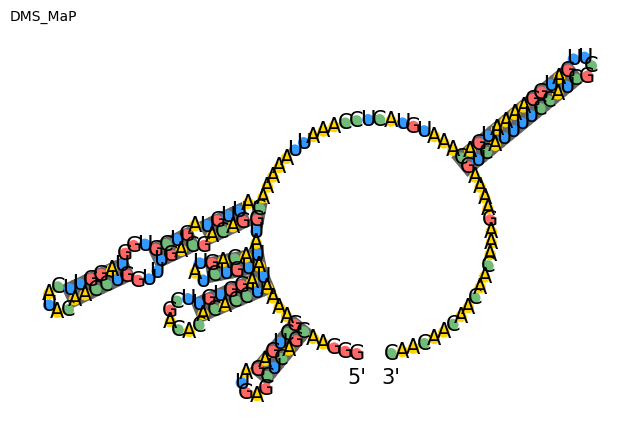

In [15]:
# Visualizing RNA  sequence for DMS MaP
rna_viz(opt_train, "DMS_MaP",  "eternafold")

sequence           GGGAACGACUCGAGUAGAGUCGAAAAGAGGCCCGGGCAACGGCCCG...
experiment_type                                              2A3_MaP
Name: 1495765, dtype: object
.....((((((.....))))))......(((((((((....))))))))..)....((....))(((.((......)).........))).......(((...(.((((((....)))))))))).(((((((((((((....))))))))))))).....................


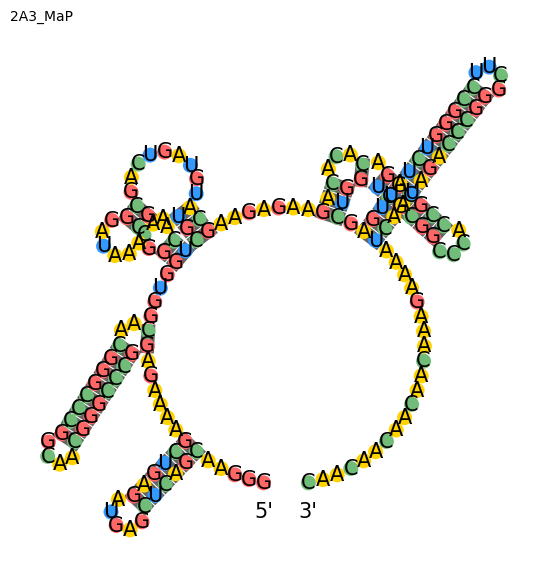

In [16]:
# Visualizing RNA  sequence for 2A3 MaP
rna_viz(opt_train, "2A3_MaP",  "eternafold")

Text(0.5, 1.0, 'Sequence lenght Distribution')

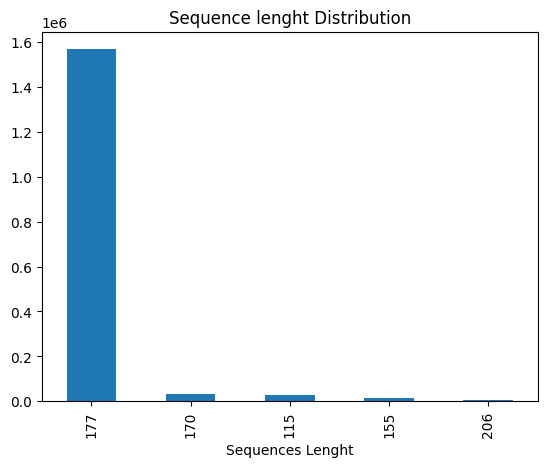

In [17]:
seq_len= opt_train.sequence.apply(len)
seq_len = seq_len.value_counts()
# seq_len = pd.Series(seq_len)
# seq_len

seq_len.plot.bar()
plt.xlabel("Sequences Lenght")
plt.title("Sequence lenght Distribution")

lengths of RNA sequence is between 115 to 206, while for the test the lengths are between 177 to 457.  Part of the challenge is to know whether the patterns recognized at length 115 to 206 will generalize to longer lengths [response found here.](https://www.kaggle.com/competitions/stanford-ribonanza-rna-folding/discussion/453147#2513582).

Text(0.5, 1.0, 'Base Count')

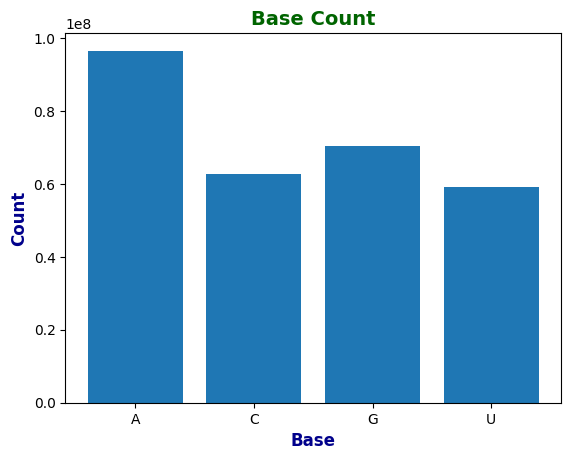

In [18]:
base= {"A": 0,"C":0,"G":0,"U":0}

for seq in opt_train.sequence:
    for base_key in base.keys():
        base[base_key] += seq.count(base_key)


plt.bar(base.keys(), base.values())
plt.xlabel('Base', fontsize = 12, fontweight = 'bold', color = 'darkblue')
plt.ylabel('Count', fontsize = 12, fontweight = 'bold', color = 'darkblue')
plt.title('Base Count', fontsize = 14, fontweight = 'bold', color = 'darkgreen')

In [19]:
del seq_len
gc.collect()

44587

In [20]:
opt_train.reads.describe()

count    1.643680e+06
mean     2.230474e+03
std      2.415467e+04
min      0.000000e+00
25%      4.200000e+01
50%      1.480000e+02
75%      5.260000e+02
max      1.474813e+07
Name: reads, dtype: float64

In [21]:
opt_train.signal_to_noise.describe()

count    1.643680e+06
mean     1.194395e+00
std      2.696888e+00
min     -1.672000e+00
25%      1.090000e-01
50%      3.830000e-01
75%      1.081000e+00
max      2.563710e+02
Name: signal_to_noise, dtype: float64

In [22]:
opt_train.SN_filter.describe()

count    1.643680e+06
mean     2.666206e-01
std      4.421925e-01
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      1.000000e+00
max      1.000000e+00
Name: SN_filter, dtype: float64

In [23]:
# checking number of columns NaN in reactivity and reactivity_error 
float_columns = opt_train.select_dtypes(include=['float'])

# Columns that are NaN
num_empty_cols= 0
cols_having_values=0


# for col in float_columns.drop('signal_to_noise', axis=1):
for col in float_columns:
    if float_columns[col].notna().sum() == 0:
        num_empty_cols+=1
    else:
        cols_having_values+=1
        
print(f"Number of Columns with only NaN values: {num_empty_cols} of 412 columns\n")
print(f"Number of Columns with values: {cols_having_values} of 412 columns")

Number of Columns with only NaN values: 134 of 412 columns

Number of Columns with values: 279 of 412 columns


In [24]:
del float_columns
gc.collect()

0

# Data Wrangling

In [25]:
def wrangle(df):
    
    # Drop rows based on SN Filter
    df= df.loc[df.SN_filter == 1]
    
    # Drop duplicate
    df= df.drop_duplicates(subset=["sequence_id", "experiment_type"])
    
    
    # Drop the columns 
    df= df.drop(columns=["reads", "signal_to_noise","SN_filter"], axis=1)
    df= df.drop(columns=[col for col in df.columns if "_error_" in col], axis=1)
  
    # Set categories for categorical columns
    for col in df.select_dtypes(include="category"):
        df[col] = df[col].cat.add_categories([0])
    
    
    # Fill NaN value for reactivity & error
    df= df[7:].fillna(0)
    
    # Reset index to start from 0
    df.reset_index(drop=True, inplace= True)
       
      
    return df

In [26]:
# get the clean dataset
train_feat=  wrangle(opt_train)

In [27]:
train_feat.head()

,sequence_id,sequence,experiment_type,dataset_name,reactivity_0001,reactivity_0002,reactivity_0003,reactivity_0004,reactivity_0005,reactivity_0006,...,reactivity_0197,reactivity_0198,reactivity_0199,reactivity_0200,reactivity_0201,reactivity_0202,reactivity_0203,reactivity_0204,reactivity_0205,reactivity_0206
0,470c8b446927,GGGAACGACUCGAGUAGAGUCGAAAAACGUCGAUAUGGAUUUACUC...,2A3_MaP,15k_2A3,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,c7712b3f912d,GGGAACGACUCGAGUAGAGUCGAAAAACGUGGAUAUGGAUUUACUC...,2A3_MaP,15k_2A3,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,61a357b74f51,GGGAACGACUCGAGUAGAGUCGAAAAACGUUAAUAUGGAUUUACUC...,2A3_MaP,15k_2A3,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,db844b9f1869,GGGAACGACUCGAGUAGAGUCGAAAAACGUUCAUAUGGAUUUACUC...,2A3_MaP,15k_2A3,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,dd685eaf9ce2,GGGAACGACUCGAGUAGAGUCGAAAAACGUUUAUAUGGAUUUACUC...,2A3_MaP,15k_2A3,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [28]:
train_feat.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 410990 entries, 0 to 410989
Columns: 210 entries, sequence_id to reactivity_0206
dtypes: category(4), float32(206)
memory usage: 371.4 MB


In [29]:
del opt_train
gc.collect()

0

# Feature Extraction and Engineering
<!-- - Mean of Bpps -->
<!-- - 3D Coords -->
<!-- - Sequence lib -->
<!-- - forming OpenKnots and the probabity using metadata -->
<!-- - Probability codons  -->
<!-- - Mean of probability of codons -->
<!-- - propbability of forming 2D and 3D structures -->
<!-- - sequence length -->
<!-- - Mean reactivity -->
<!-- - secondary structure and its' count [UMAR IGAN](https://www.kaggle.com/code/umar47/rna-folding-reduce-memory-add-features-seq2seq?scriptVersionId=147271807&cellId=31) -->
<!-- - Adjacent Guanines count -->

### energetics and structure 
Using the arnie package, to get the following features.
- Bpps Thank to [JOCELYN DUMLAO](https://www.kaggle.com/jocelyndumlaohttps://www.kaggle.com/jocelyndumlao)
- Dot-bracket notation
- Free energy
- pair and unpaired vector

In [30]:
# funcitons to get energitcis and structure data

def energtics_structure_parallel(sequence, package):
    """Get the secondary features for an RNA sequence, 
    derived using arnie and eternafold packages
    
    Parameters
    ----------
    sequence: str
        sequence of bases for an RNA
    
    Returns
    -------
    features: DataFrame
    - Minimum free energy (dot notation)
    - free energy 
    """
    def process_seq(seq):
        seq_info = {}
        
        # Temporarily redirect stderr to suppress the warning message
        original_stderr = sys.stderr
        sys.stderr = open(os.devnull, 'w')

        try:
            seq_info["mfe"] = mfe(seq, package)
            seq_info["free_energy"] = free_energy(seq, package)
        finally:
            # Restore stderr to its original value
            sys.stderr.close()
            sys.stderr = original_stderr
        return seq_info

    with ThreadPoolExecutor() as executor:
        struc_energ = list(executor.map(process_seq, sequence))


    df = pd.DataFrame(struc_energ)
    return df



def process_data_in_batches(data, batch_size, name, package):
    """Process large RNA sequence data in batches
        
    Parameters
    ----------
    data: str
        List of RNA sequence data
    
    batch_size: int
        size or number of rows for each batch
    
    name: str
        name for processed dataset
    
    Returns
    -------
        creates csv files for each processed batch
    """
    # Get batches
    total_count = len(data)
    chunks = (total_count - 1) // batch_size + 1 
        
    
    with tqdm(total=chunks, desc="Processing Batches") as pbar: # progress bar for batch processing
        sleep(0.1)
        for i in range(chunks):
            batch = data[i * batch_size: (i + 1) * batch_size]
            
            filename = f'{name}_struc_{i + 1}.csv'
            feat_path= glob.glob("/kaggle/input/features-data/*.csv")
            
        
            if os.path.exists(filename) or filename in feat_path: 
                last_row = pd.read_csv(filename).iloc[-1].tolist()
            else:
                energtics_structure_parallel(batch, package).to_csv(filename)
                
            pbar.update(1)  # Increment the progress 

        # Cleanup: remove all .ps files
        for file in glob.glob("/kaggle/working/*.ps"):
            os.remove(file)
            print(f"Removed temporary file: {file}")
        
        # Release unreferenced memory
        del batch
        gc.collect()
        

In [31]:
# get mfe and free energy
data= train_feat.sequence[:10]
batch_size= 100
name= "train_mfe_free_e"
package= "eternafold"
process_data_in_batches(data, batch_size, name, package)

Processing Batches:   0%|          | 0/1 [00:00<?, ?it/s]

b'WARNING: structure constraint is missing\nWARNING: structure constraint is missing\n'
b'WARNING: structure constraint is missing\nWARNING: structure constraint is missing\n'
b'WARNING: structure constraint is missing\nWARNING: structure constraint is missing\n'
b'WARNING: structure constraint is missing\nWARNING: structure constraint is missing\n'
b'WARNING: structure constraint is missing\nWARNING: structure constraint is missing\n'
b'WARNING: structure constraint is missing\nWARNING: structure constraint is missing\n'
b'WARNING: structure constraint is missing\nWARNING: structure constraint is missing\n'
b'WARNING: structure constraint is missing\nWARNING: structure constraint is missing\n'
b'WARNING: structure constraint is missing\nWARNING: structure constraint is missing\n'
b'WARNING: structure constraint is missing\nWARNING: structure constraint is missing\n'
Removed temporary file: /kaggle/working/bsqbvn_0002_dp.ps
Removed temporary file: /kaggle/working/tsjnmv_0002_dp.ps
Remo

In [33]:
# read the structure csv file into pandas
pd.read_csv("/kaggle/working/train_mfe_free_e_struc_1.csv").head()

,Unnamed: 0,mfe,free_energy
0,0,.....((((((.....))))))......((.(((..((((((((((...,-57.31
1,1,.....((((((.....)))))).....(((((((..((((((((((...,-62.73
2,2,.....((((((.....))))))......(((.....((((((((((...,-56.35
3,3,.....((((((.....))))))......((......((((((((((...,-63.25
4,4,.....((((((.....))))))......((......((((((((((...,-58.22


In [34]:
bp= bpps(train_feat.sequence[0], package="eternafold")
print(len(bp))
print(bp.shape)
print(bp)

170
(170, 170)
[[0.         0.         0.         ... 0.         0.         0.00037676]
 [0.         0.         0.         ... 0.         0.         0.00021681]
 [0.         0.         0.         ... 0.         0.         0.00015175]
 ...
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.00037676 0.00021681 0.00015175 ... 0.         0.         0.        ]]


In [52]:
# Function to get bpp

def get_bpps_and_save(seqs, filename):
    bp_matrix= []
    bp_matrix_dict= {"bp_matrix": bp_matrix}
    for seq in seqs:
        bp_matrix.append(bpps(seq, package="eternafold"))
    # Create Dataframe
    df= pd.DataFrame(bp_matrix_dict, columns=["bp_matrix"])
    # Save to parquet
    df.to_parquet(f"{filename}.parquet")
    print(f"Successfully saved DataFrame to {filename}.parquet")
    return df
        


bp_matrix= get_bpps_and_save(train_feat.sequence[:5], "bpps_mat")

Successfully saved 5 matrices to bpps_mat.


In [ ]:
# get bpps and saving using np.save

# def get_bpps_and_save(seqs, filename):
#     """
#     Gets base pair probability matrices and saves them in .npy format.

#     Args:
#         seqs (list): A list of RNA sequences.
#         filename (str): The name of the file to save the data.
#     """
#     bp_matrices = []
#     for seq in seqs:
#         # Assuming bpps() returns a NumPy array
#         bp_matrices.append(bpps(seq, package="eternafold"))
    
#     # Save the list of arrays as a single .npy file
#     np.save(filename, bp_matrices)
#     print(f"Successfully saved {len(bp_matrices)} matrices to {filename}.")

In [56]:
# import bp_matrix array 

# Load the data back into a list of NumPy arrays
# loaded_bp_matrices = np.load("bpps_mat.npy", allow_pickle=True)

# You can now access each array directly
# print(f"Loaded a list of {len(loaded_bp_matrices)} matrices.")
# print(f"Shape of array {len(loaded_bp_matrices.shape)}.")
# print(f"Shape of the first matrix: {loaded_bp_matrices[0].shape}")
# print(loaded_bp_matrices[0])

Loaded a list of 5 matrices.
Shape of array 3.
Shape of the first matrix: (170, 170)
[[0.         0.         0.         ... 0.         0.         0.00037676]
 [0.         0.         0.         ... 0.         0.         0.00021681]
 [0.         0.         0.         ... 0.         0.         0.00015175]
 ...
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.00037676 0.00021681 0.00015175 ... 0.         0.         0.        ]]


In [58]:
# read into pandas
bp_matrix= pd.Series(loaded_bp_matrices)

bp_matrix

ValueError: Data must be 1-dimensional, got ndarray of shape (5, 170, 170) instead

In [49]:
print("Data type", type(bp_matrix.bp_matrix[0]))
print("\n")
print("\n")
bp_matrix.bp_matrix[0]

Data type <class 'numpy.ndarray'>






array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.00037676],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.00021681],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.00015175],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.00037676, 0.00021681, 0.00015175, ..., 0.        , 0.        ,
        0.        ]])

In [ ]:
import numpy as np
import io

# Your string output, as a variable
string_data = bp_matrix.bp_matrix[0]

# Clean the string by removing brackets and the ellipsis.
# `np.loadtxt` will handle the newlines.
cleaned_string = string_data.replace('[', '').replace(']', '').replace('...', '')
string_io = io.StringIO(cleaned_string)

# Use np.loadtxt to read the numbers from the string, which results in a 1D array.
bp_matrix_flat = np.loadtxt(string_io)

# Reshape the 1D array into the correct 2D matrix shape of (170, 170).
bp_matrix = bp_matrix_flat.reshape(170, 170)

print(f"Data type: {type(bp_matrix)}")
print(f"Array shape: {bp_matrix.shape}")
print(bp_matrix)

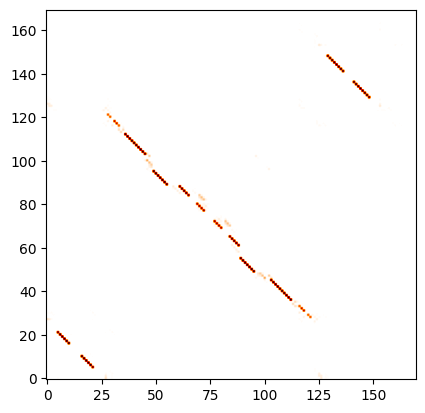

In [51]:
# Visualize a sample matrix
bp_m= bp_matrix.bp_matrix[0]
plt.imshow(bp_m, origin='lower', cmap='gist_heat_r')

In [ ]:
# get the total probability that nucleotide i is paired for each sequence
# This gives us a prediction of how accessible the nucleotide is, which is important in a lot of contexts -- 
# a prediction for structure probing data, a prediction for degradation rate, and possibly a prediction for protein binding.

def get_p_unp_vec(bp_matrix):
    p_unp_vec= {}
    p_unp_vec["p_unp_vec"] = 1 - np.sum(bp_matrix, axis=0)
    p_unp_vec= pd.DataFrame(p_unp_vec, columns= ["p_unp_vec"])

In [ ]:
# get a slice 20 000 of the train data
train_sliced= train_feat[:10_000]

In [ ]:
# %%time
# Get the Secondary features for train and test datasets
process_data_in_batches(train_feat.sequence, 50_000, "train")

In [ ]:
pd.read_csv("/kaggle/input/features-data/train_sec_struc_1.csv").head()

In [ ]:
# concatenating csv files into a csv file for test and training data

def csv_concat(file_path, name):
    """ Combine all the csv files into one file
    
    Parameter
    ---------
    file_path: str
        path to the csv files
    
    name: str
        name of combined csv file
    
    
    Returns
    -------
    combined csv file
    
    """

    # Create a list of CSV files  to append
    file_list = os.listdir(file_path)
    extract_numeric_part = lambda x: int(x.split('_')[3].split('.')[0])
    sorted_file_list = sorted(file_list, key=extract_numeric_part)

    # Read each CSV file into a DataFrame
    combined_csv = pd.concat([pd.read_csv(f"{file_path}/{f}") for f in sorted_file_list], ignore_index=True)

    # Export the combined DataFrame to a single CSV file
    combined_csv.to_csv(f"features_data/{name}.csv", index=False)
    

In [ ]:
# download the features data for test and trian

# !gsutil -m cp \
# !  "gs://kaggle-competition-402916-eu-notebooks/europe-west2-a/instance-20231122-222833/Kaggle-Competition----Stanford-Ribonanza-RNA-Folding/features_data/combined_features/combine_test.csv" \
# !  "gs://kaggle-competition-402916-eu-notebooks/europe-west2-a/instance-20231122-222833/Kaggle-Competition----Stanford-Ribonanza-RNA-Folding/features_data/combined_features/combine_train.csv" \


# ! wget https://storage.cloud.google.com/kaggle-competition-402916-eu-notebooks/europe-west2-a/instance-20231122-222833/Kaggle-Competition----Stanford-Ribonanza-RNA-Folding/features_data/combined_features/combine_test.csv?_ga=2.10857908.-1088134625.1698079045
# ! wget https://storage.cloud.google.com/kaggle-competition-402916-eu-notebooks/europe-west2-a/instance-20231122-222833/Kaggle-Competition----Stanford-Ribonanza-RNA-Folding/features_data/combined_features/combine_train.csv?_ga=2.10857908.-1088134625.1698079045    

In [ ]:
# Concatenate the energetics and structure csv files

csv_concat("train_features", "combine_train")

csv_concat("test_features", "combine_test")


combine_train_features= pd.read_csv("combine_train.csv")
check.shape
combine_test_features= pd.read_csv("combine_test.csv")
check.shape

In [ ]:
# import structure and bpps to data

train_struc_bpps= pd.read_csv("train_struc_bpps.csv")
test_struc_bpps= pd.read_csv("test_struc_bpps.csv")

print(f"train extracted features shape: {test_struc_bpps.shape}\ntest extracted features shape {"test_struc_bpps"}")

### sequence lenght

In [ ]:
# lenght of sequence to a column
train_feat["sequnece_len"]= train_feat.sequence.astype(str).apply(len)
opt_test["sequnece_len"]= opt_test.sequence.apply(len)

train_feat

In [ ]:
opt_test.info()

### mean reactivity

In [ ]:
# Get the mean of reactivity columns 
train_feat["react_mean"]= train_feat[reactivity_cols].mean(axis=1)
train_feat

In [ ]:
# Calculate mean BPPs

train_struc_bpps["avg_bpps"]= train_seq_bpp.mean(axis=1)
test_struc_bpps["avg_bpps"] = test_seq_bpp.mean(axis=1)


# print(f"Train dataset shape: {train_struc_bpps}")
# print(f"Test dataset shape: {test_struc_bpps}")

In [ ]:
# Function to count parentheses
def count_parentheses(structure_string):
    count = structure_string.count(")")
    return count

# Apply the function to the DataFrame column

tq.pandas()
train_struc_bpps['parentheses_counts'] = train_struc_bpps['sec_structure'].astype(str).apply(count_parentheses)
test_struc_bpps['parentheses_counts'] = test_struc_bpps['sec_structure'].astype(str).apply(count_parentheses)

### codon features
codon count, cps of sequence, codon probability

In [ ]:
from collections import Counter

def codons_feats(seq):
    codons = Counter(seq[i:i+3] for i in range(0, len(seq), 3))
    pairs = Counter(seq[i:i+6] for i in range(0, len(seq)-1, 3))
    cps = 0
    for pair in pairs:
        if codons[pair[:3]] == 0 or codons[pair[3:]] == 0:
            continue
        cps += pairs[pair]/(codons[pair[:3]]*codons[pair[3:]])
    return {'codons': codons, 'pairs': pairs, 'cps': cps}

In [ ]:
# Get the codons, pairs, cps for train sequences
# codon_feat= []

# for seq in train_feat.sequence:
#     codon_feat.append(codons_feats(seq))

# # codon_feat= pd.DataFrame(train_feat.sequence.iloc[5:10].apply(codons_feats), columns= ["codons", "pairs", "cps"])
# codon_feat= pd.DataFrame(codon_feat, columns=["codons", "pairs", "cps"])
# codon_feat.to_csv("train_codon_feat.csv")

# codon_feat.head()

In [ ]:
# Get the codons, pairs, cps for test sequences
# codon_feat= []

# for seq in opt_test.sequence:
#     codon_feat.append(codons_feats(seq))

# # codon_feat= pd.DataFrame(train_feat.sequence.iloc[5:10].apply(codons_feats), columns= ["codons", "pairs", "cps"])
# codon_feat= pd.DataFrame(codon_feat, columns=["codons", "pairs", "cps"])
# codon_feat.to_csv("test_codon_feat.csv")

In [ ]:
# Define functionto calculate codon probabiltiy
def codon_probs_mean(seq):
#     probs = seq.apply(RNA.codon_prob)
    probs = [RNA.codon_prob(seq) for s in seq]
    mean_probs= sum(probs.values()) / len(probs)
    probs_mean= pd.DataFrame({"probs":probs, "mean_probs": mean_probs})
    
    return probs_mean


train_condon_probs_mean= codon_probs_mean(train_feat.sequence[:10])
train_condon_probs_mean
# train_condon_probs_mean.to_csv("train_condon_probs_mean.csv")

# test_condon_probs_mean= codon_probs_mean(opt_test.sequence)
# test_condon_probs_mean.to_csv("test_condon_probs_mean.csv")

### count of adjecent guanines in sequence

In [ ]:
# function to count adjacent guanines in a codon

def gg_count(seq):
    """
    Returns:
    list of adjcent gg or ggg counts for each sequence
    """
    adj_guanine= []
    # Count the number of adjacent guanines
    for s in seq:
    adj_guanine.append(gg_count = 0)
    for i in range(len(s) - 1):
        if s[i:i+2] == "GG" or "GGG":
            gg_count += 1
            
    return gg_seq_num


train_struc_bpps["adj_guanine"]= gg_count(train_feat.sequence)
test_struc_bpps["adj_guanine"]= gg_count(opt_test.sequence)

### concatenate features into datasets

In [ ]:
# Concatenate All features to one Dataset called features and test_features

features= pd.concat([train_feat,train_struc_bpps, train_condon_probs_mean])
test_features= pd.concat([opt_test,test_struc_bpps,test_condon_probs_mean])

In [ ]:
del train_feat
del opt_test
del train_struc_bpps
del test_struc_bpps
del train_condon_probs_mean
del test_condon_probs_mean

gc.collect()

## secondary structures data

In [ ]:
# Import eterna openknot dataset
# eterna_pos= pd.read_table("/kaggle/input/stanford-ribonanza-rna-folding/eterna_openknot_metadata/Positives240-2000.tsv", sep="\\t")
# eterna_puz_132= pd.read_csv("/kaggle/input/stanford-ribonanza-rna-folding/eterna_openknot_metadata/puzzle 12378132.tsv", sep= "\\t")
# eterna_puz_RYOP50= pd.read_csv("/kaggle/input/stanford-ribonanza-rna-folding/eterna_openknot_metadata/puzzle_11318423_RYOP50_with_description.tsv", sep= "\\t")
# eterna_puz_RYOP90= pd.read_csv("/kaggle/input/stanford-ribonanza-rna-folding/eterna_openknot_metadata/puzzle_11387276_RYOP90_with_description.tsv", sep= "\\t")
# eterna_puz_RFAM= pd.read_csv("/kaggle/input/stanford-ribonanza-rna-folding/eterna_openknot_metadata/puzzle_11627601_with_descriptions_PLUS_RFAM.tsv", sep= "\\t")
# eterna_puz_118= pd.read_csv("/kaggle/input/stanford-ribonanza-rna-folding/eterna_openknot_metadata/puzzle_11836497_with_description.tsv", sep= "\\t")

In [ ]:
# # Import Supplementary Silico prediction, that is, secondary structure predictions
# gpn15k_preds= pd.read_csv("/kaggle/input/stanford-ribonanza-rna-folding/supplementary_silico_predictions/GPN15k_silico_predictions.csv")
# pk50_preds= pd.read_csv("/kaggle/input/stanford-ribonanza-rna-folding/supplementary_silico_predictions/PK50_silico_predictions.csv")
# pk90_preds= pd.read_csv("/kaggle/input/stanford-ribonanza-rna-folding/supplementary_silico_predictions/PK90_silico_predictions.csv")
# r1_preds= pd.read_csv("/kaggle/input/stanford-ribonanza-rna-folding/supplementary_silico_predictions/R1_silico_predictions.csv")

In [ ]:
# gpn15k_preds.shape
# gpn15k_preds.head()
# pk50_preds.shape
# pk50_preds.head()
# pk90_preds.shape
# pk90_preds.head()
# r1_preds.shape
# r1_preds.head()

# Building Model

In [ ]:
from keras.models import Model
from keras.layers import Dense, Conv1D, Flatten, Input, concatenate

# sequence input (assuming one-hot encoded sequences of length 4)
sequence_input = Input(shape=(None, 4))
conv1 = Conv1D(64, kernel_size=3, activation='relu')(sequence_input)
conv2 = Conv1D(32, kernel_size=3, activation='relu')(conv1)
flat = Flatten()(conv2)

# numerical/categorical input
numerical_input = Input(shape=(4,))
dense1 = Dense(32, activation='relu')(numerical_input)

# concatenate sequence and numerical inputs
concat = concatenate([flat, dense1])

# output layer
output = Dense(1, activation='sigmoid')(concat)

# create a model
model = Model(inputs=[sequence_input, numerical_input], outputs=output)

# compile model using MAE as a measure of model performance
model.compile(optimizer='adam', loss='mean_absolute_error')
